# 图像的合成与融合
Hawk Wang


** 请关注我的知乎专栏[https://zhuanlan.zhihu.com/hawkcp], 获取更多信息 **


### 0. 导入必要的库
首先还是将这里用到的所有的python package引用进来

- Image及skimage中的imread: 用于读取图像
- numpy: 用于用矩阵形式来管理图像
- matplotlib: 用于可视化数据
- cv2: 即OpenCV，用于对图像进行高级的处理
- scipy.fftpack: 傅里叶变化库

特别注意的是，为了在notebook中顺利的可视化图像，通常需要加入如下这一句：

```%matplotlib inline```

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread
from scipy.fftpack import ifftn, fft2, ifft2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmath
import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')

### 1. cut-and-paste

我们来尝试生成如下的图片：

![](./imgs/7_billgates.jpg)

首先读取原始的输入图像及掩模图像并显示

In [77]:
imgBuilding=np.array(Image.open("./imgs/1_imgBuilding.jpg"))
imgBuildingMask=np.array(Image.open("./imgs/2_imgBuildingMask.jpg"))
imgBill=np.array(Image.open("./imgs/3_imgBill.jpg"))
imgBillMask=np.array(Image.open("./imgs/4_imgBillMask.jpg"))
imgBill=imgBill[0:imgBill.shape[0]-1]

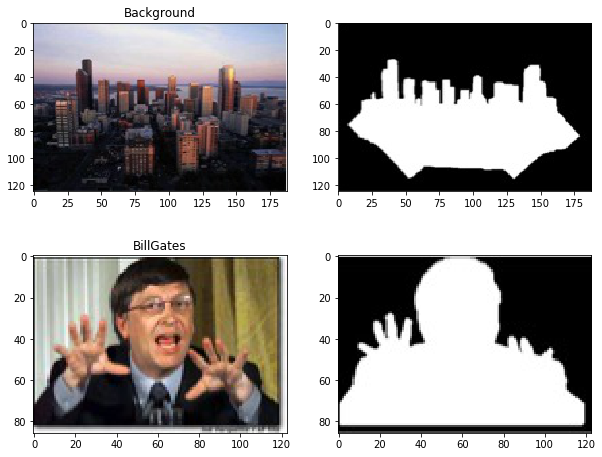

In [79]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(imgBuilding)
plt.title("Background")
plt.subplot(2,2,2)
plt.imshow(imgBuildingMask)
plt.subplot(2,2,3)
plt.imshow(imgBill)
plt.title("BillGates")
plt.subplot(2,2,4)
plt.imshow(imgBillMask)
plt.show()

然后按顺序获取三层不同的图像，这里只是用了很简单的赋值方法

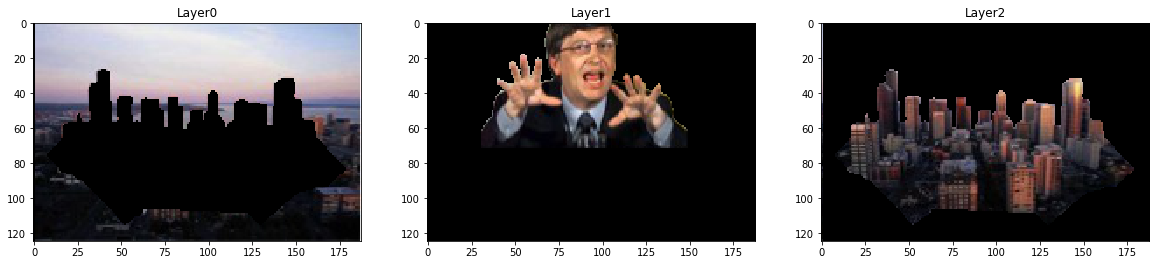

In [80]:
layer0 = imgBuilding.copy()
layer0[imgBuildingMask>128]=0
layer1 = np.zeros(imgBuilding.shape, imgBuilding.dtype)
layer1Mask=np.zeros(imgBuildingMask.shape, imgBuildingMask.dtype)
imgBill[imgBillMask<128]=0
layer1[0:imgBill.shape[0]-10, 30:imgBill.shape[1]+30]=imgBill[10:imgBill.shape[0]]
layer1Mask[0:imgBill.shape[0]-10, 30:imgBill.shape[1]+30]=imgBillMask[10:imgBillMask.shape[0]]
layer2 = imgBuilding.copy()
layer2[imgBuildingMask<128]=0

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(layer0)
plt.title("Layer0")
plt.subplot(1,3,2)
plt.imshow(layer1)
plt.title("Layer1")
plt.subplot(1,3,3)
plt.imshow(layer2)
plt.title("Layer2")
plt.show()

最后只需要按顺序将每一层叠加起来即可，依然使用了一些布尔量来做判断

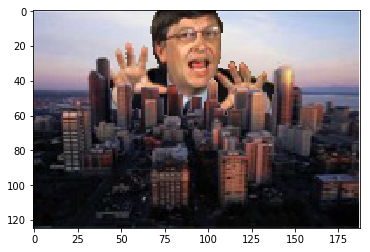

In [81]:
layer0[layer1Mask>128]=layer1[layer1Mask>128]
layer0[imgBuildingMask>128]=layer2[imgBuildingMask>128]
plt.imshow(layer0)
plt.show()

可以看到Cut-and-paste得到了不错的结果。 但这种方法由于原理过于简单粗暴，很多时候无法得到很好的结果，所以我们可以看看Alpha融合

### 2. Alpha融合

### 例1: 简单mask

为了做Alpha融合，我们需要读取原图和对应的Alpha Mask：

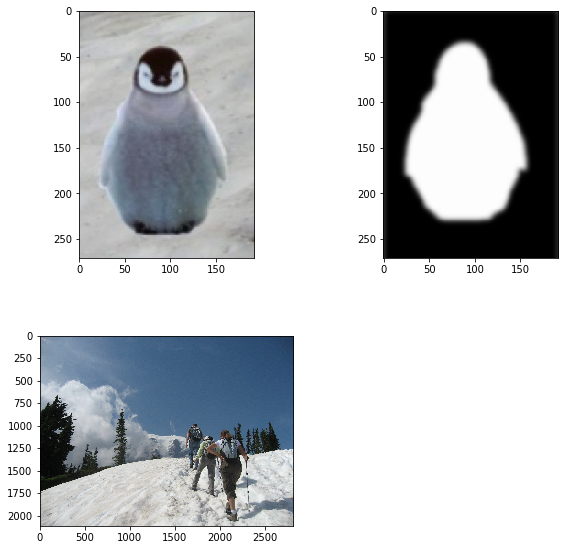

In [161]:
imgPenguin=np.array(Image.open("./imgs/9_penguin.jpg"))
imgPenguinMask=np.array(Image.open("./imgs/10_mask.jpg"))
imgHiking = np.array(Image.open("./imgs/8_hiking.jpg"))
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(imgPenguin)
plt.subplot(2,2,2)
plt.imshow(imgPenguinMask)
plt.subplot(2,2,3)
plt.imshow(imgHiking)
plt.show()

接下来先对Mask图做高斯滤波，羽化它的边缘

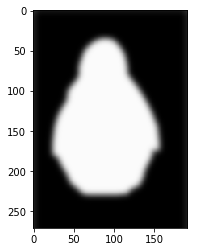

In [162]:
imgPenguinMask=cv2.GaussianBlur(imgPenguinMask, (15, 15), -1)
plt.imshow(imgPenguinMask)
plt.show()

然后利用公式$OutputImage = \alpha * forgoundImage + (1 - \alpha)*backgroundImage$进行Alpha融合

In [165]:
imgPenguinMaskNorm = imgPenguinMask.astype(np.float) / imgPenguinMask.max()
outputImage = imgHiking.copy()
targetTop = 1750
targetLeft=1000
outputImage[targetTop:targetTop+imgPenguin.shape[0], targetLeft:targetLeft+imgPenguin.shape[1]] = imgPenguinMaskNorm * imgPenguin + (1 - imgPenguinMaskNorm) * outputImage[targetTop:targetTop+imgPenguin.shape[0], targetLeft:targetLeft+imgPenguin.shape[1]]

看看结果图

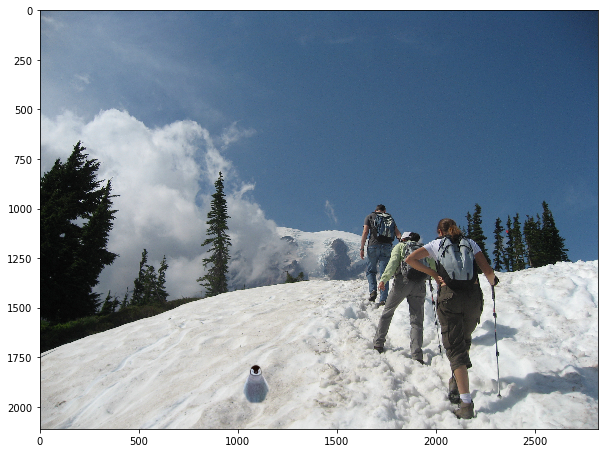

In [168]:
plt.figure(figsize=(10,10))
plt.imshow(outputImage)
plt.show()

### 例2: center seam，复杂Mask

先读入原始图片

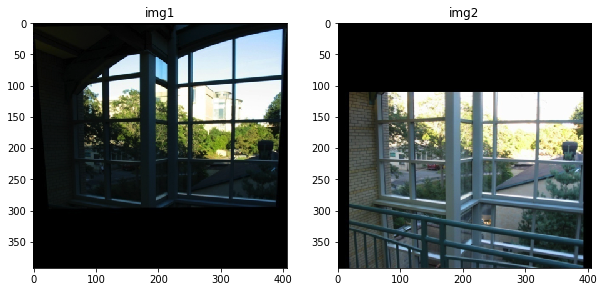

In [211]:
img1=cv2.imread('./imgs/11_img1.png')[:,:,::-1]
img2=cv2.imread('./imgs/12_img2.png')[:,:,::-1]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("img1")
plt.imshow(img1,cmap=cm.gray)
plt.subplot(1,2,2)
plt.title("img2")
plt.imshow(img2,cmap=cm.gray)
plt.show()

再计算距离转换图像(distance transform image)

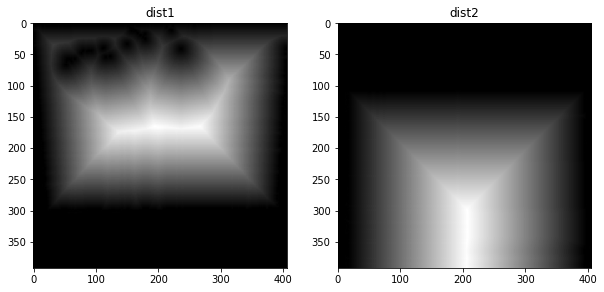

In [212]:
img1Gray=cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
imgDist1=cv2.distanceTransform(img1Gray, distanceType=cv2.DIST_L2, maskSize=5)
img2Gray=cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
imgDist2=cv2.distanceTransform(img2Gray, distanceType=cv2.DIST_L2, maskSize=5)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(imgDist1, cmap="gray")
plt.title("dist1")
plt.subplot(1,2,2)
plt.imshow(imgDist2, cmap="gray")
plt.title("dist2")
plt.show()

采用公式$alpha = \frac{dist1}{dist1+dist2}$ 计算 Alpha Mask

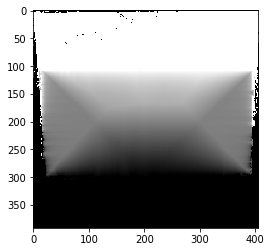

In [216]:
imgAlpha = imgDist1/(imgDist1+imgDist2+1e-5)
plt.imshow(imgAlpha, cmap="gray")
plt.show()

融合两张图像并显示

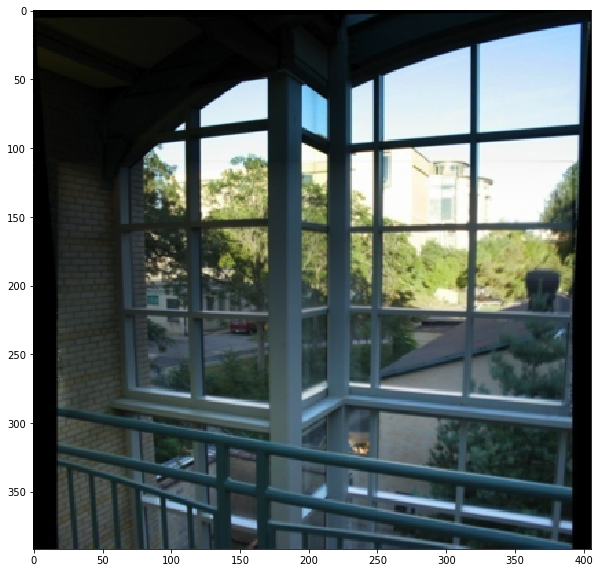

In [219]:
imgBlend12 = img1.copy()
for c in range(3):
    imgBlend12[:,:,c]=img1[:,:,c] * imgAlpha + img2[:,:,c]*(1-imgAlpha)

plt.figure(figsize=(10,10))
plt.imshow(imgBlend12, cmap="gray")
plt.show()

Alpha融合是一种最简单的线性融合，为了提高融合的质量还可以用更复杂的多频段融合方法

### 3. 多频段融合

这里我主要给大家展示直接利用OpenCV的多频段融合函数来完成融合

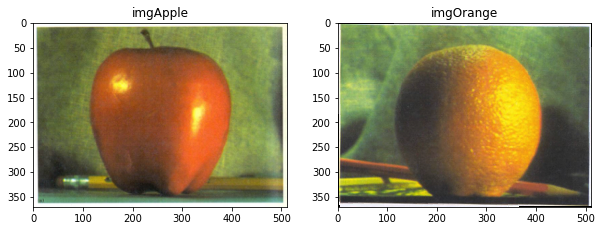

In [270]:
imgApple=cv2.imread("./imgs/13_apple.png")[:,:,::-1]
imgOrange=cv2.imread("./imgs/14_orange.png")[:,:,::-1]
imgOrange=imgOrange[3:-3, 1:-2]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("imgApple")
plt.imshow(imgApple,cmap=cm.gray)
plt.subplot(1,2,2)
plt.title("imgOrange")
plt.imshow(imgOrange,cmap=cm.gray)
plt.show()

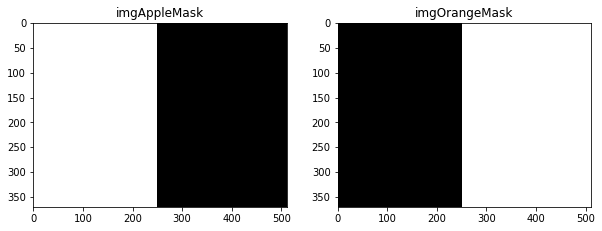

In [271]:
imgAppleMask=np.ones(imgApple.shape[0:2], np.uint8)*255
imgOrangeMask=np.ones(imgOrange.shape[0:2], np.uint8)*255
imgAppleMask[:,250:-1]=0
imgOrangeMask[:,0:250]=0
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("imgAppleMask")
plt.imshow(imgAppleMask,cmap=cm.gray)
plt.subplot(1,2,2)
plt.title("imgOrangeMask")
plt.imshow(imgOrangeMask,cmap=cm.gray)
plt.show()

In [272]:
blender=cv2.detail_MultiBandBlender()
roiRect=(0, 0, imgApple.shape[1], imgApple.shape[0])
blender.prepare(roiRect)
blender.feed(imgApple, imgAppleMask, (0,0))
blender.feed(imgOrange, imgOrangeMask, (0,0))
imgBlendAO=imgApple.copy()
dst,dst_mask=blender.blend(imgBlendAO, imgAppleMask)

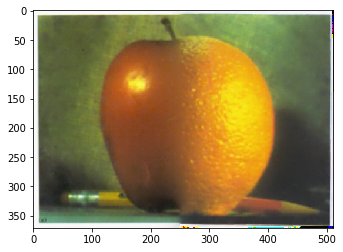

In [273]:
plt.imshow(dst.astype(np.uint8))
plt.show()

### 4. 总结

我在专栏中讲到了图像的合成和rong'he。这份Notebook用一些实例来展示了相关知识。

欢迎你继续关注本仓库，也欢迎关注我的知乎专栏 ”计算摄影学“：https://zhuanlan.zhihu.com/hawkcp